In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import glob
from pathlib import Path

DATA_DIR = Path("../data/daily_tardis/trades")
use_cols   = ["timestamp", "price", "amount"]

Found 31 daily trade files
                         timestamp    price  amount
0 2025-01-01 00:00:03.428000+00:00  3331.10    9140
1 2025-01-01 00:00:16.147000+00:00  3330.35       6
2 2025-01-01 00:00:16.148000+00:00  3330.30       4
3 2025-01-01 00:00:16.602000+00:00  3329.60     618
4 2025-01-01 00:00:17.772000+00:00  3329.60     618


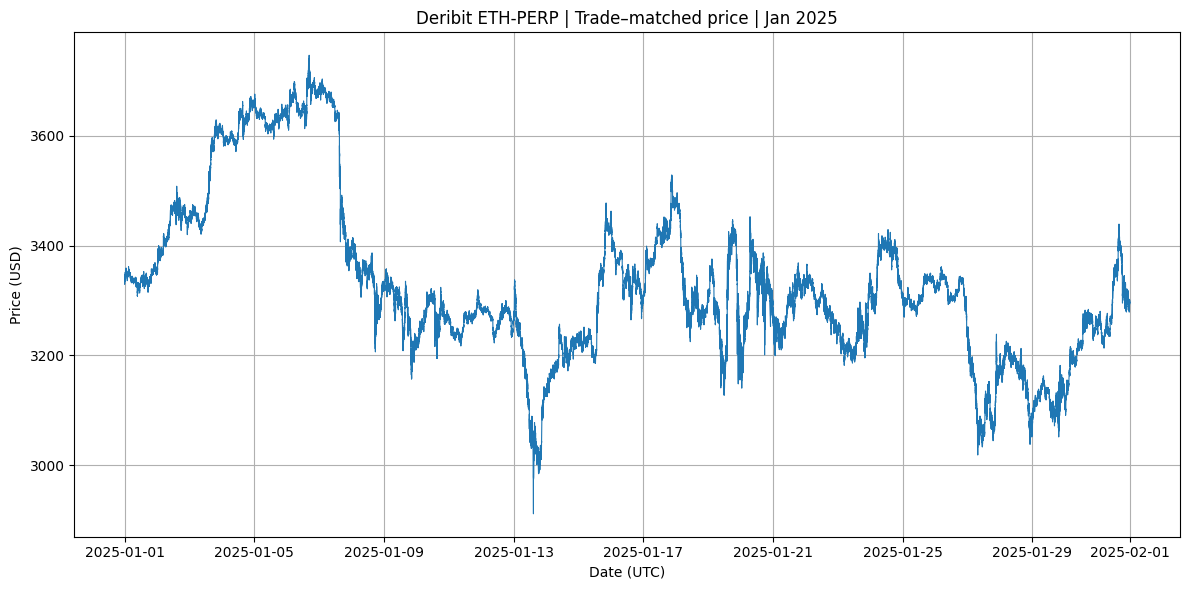

                                Value
Open (1 Jan)                 3,331.10
Close (31 Jan)               3,300.60
High                         3,746.60
Low                          2,911.70
Volume ETH           7,937,306,018.00
Volume USD      26,273,902,310,756.75


C:\Users\codri\AppData\Local\Temp\ipykernel_15036\2870369251.py:46: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(month_stats.applymap(lambda x: f"{x:,.2f}" if isinstance(x, float) else x))


In [12]:
files = sorted(glob.glob(str(DATA_DIR / "deribit_trades_2025-01-*_ETH-PERPETUAL.csv.gz")))
print(f"Found {len(files)} daily trade files")

dfs = [
    pd.read_csv(f, compression="gzip", usecols=use_cols)
        .assign(timestamp=lambda d: pd.to_datetime(d.timestamp, unit='us', utc=True))
    for f in files
]

trades = (
    pd.concat(dfs, ignore_index=True)
      .sort_values("timestamp")
      .set_index("timestamp")
)
trades["notional"] = trades["price"] * trades["amount"]

daily_price   = trades["price"].resample("1D").ohlc()
daily_vol_qty = trades["amount"].resample("1D").sum()
daily_vol_usd = trades["notional"].resample("1D").sum()

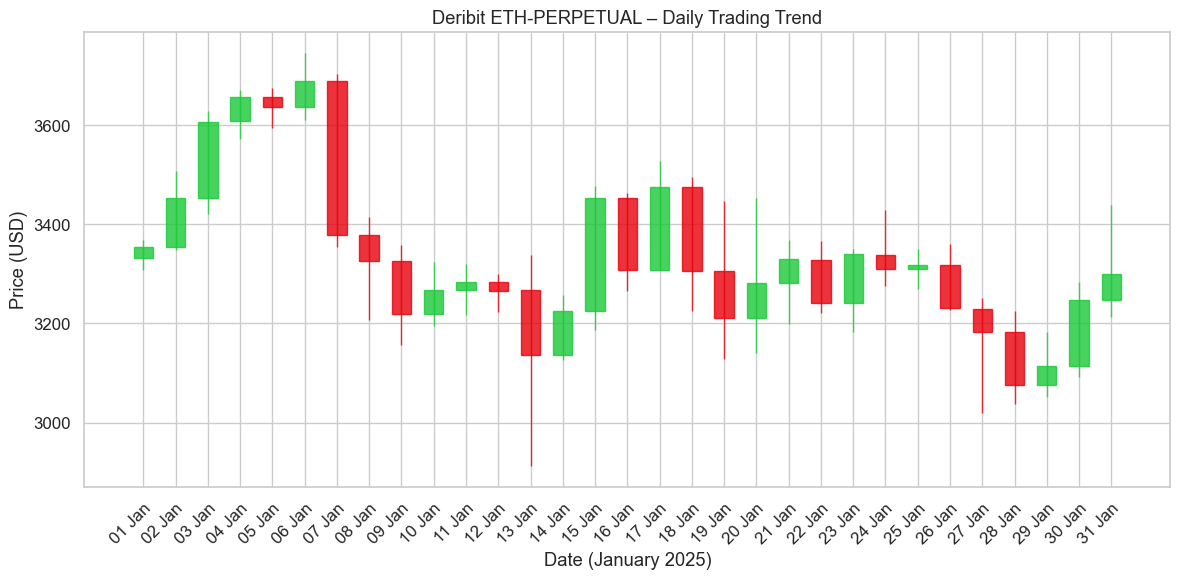

In [43]:
sns.set_theme(style="whitegrid", font_scale=1.1)
palette = sns.color_palette("bright", 8)
up_col, down_col = palette[2], palette[3]

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(daily_price))

width = 0.6
for idx, day in enumerate(daily_price.itertuples()):
    o, h, l, c = day.open, day.high, day.low, day.close
    color = up_col if c >= o else down_col

    ax.vlines(idx, l, h, linewidth=1, color=color, alpha=0.8)
    lower = min(o, c)
    height = abs(c - o)
    body = Rectangle((idx - width/2, lower),
                     width, max(height, 1e-5),
                     facecolor=color, edgecolor=color, alpha=0.8)
    ax.add_patch(body)

ax.set_xticks(x)
ax.set_xticklabels(
    [d.strftime("%d %b") for d in daily_price.index],
    rotation=45,
    ha="right",
    rotation_mode="anchor"
)

ax.set_title("Deribit ETH-PERPETUAL – Daily Trading Trend")
ax.set_ylabel("Price (USD)")
ax.set_xlabel("Date (January 2025)")

plt.tight_layout()
plt.savefig("../plots/candle_jan_2025.png", dpi=300, bbox_inches="tight")
plt.show()